In [37]:
import pickle
import re 
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import twitter_samples 
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer  



import sklearn
from sklearn import metrics 
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB,ComplementNB,BernoulliNB  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import confusion_matrix 
from xgboost import XGBClassifier 


import warnings 

warnings.filterwarnings("ignore")

In [38]:
print(sklearn.__version__)

0.24.2


# Importing Dataset

In [39]:
Dataset=pd.read_csv("../input/dataset/dataset_.csv") 
Dataset.head()

,Unnamed: 0,sentiment,id,Date,Query,User,text
0,0,4,2063289082,Sun Jun 07 02:04:01 PDT 2009,NO_QUERY,DeniseSD12,I'm home. soo tired. NEED. SOME. REST. :|
1,1,4,1687530883,Sun May 03 08:56:33 PDT 2009,NO_QUERY,LadyHhugs,My breakfast... Lowfat blueberry muffin.. Peac...
2,2,0,2296933721,Tue Jun 23 09:49:08 PDT 2009,NO_QUERY,Akalyah,Ewwwwwwwwwwwwwww I just stepped on a snail.....
3,3,4,2191904836,Tue Jun 16 06:10:32 PDT 2009,NO_QUERY,Bhavnay,www.trainofpearls.wordpress.com been blogging ...
4,4,0,1794351602,Thu May 14 05:36:30 PDT 2009,NO_QUERY,Carlabrown19,First exam a week today-i have soooo much to l...


In [40]:
#Printing dataset shape 

print(Dataset.shape)

(60000, 7)


In [41]:
# Finding numnber of not defined values in each columns 

print(Dataset.isna().sum())

Unnamed: 0    0
sentiment     0
id            0
Date          0
Query         0
User          0
text          0
dtype: int64


In [42]:
#Finding number of possitive and negative sentiments   
# 4 represents possitive sentiments  
# 0 represents negative sentiments  
#Replacing 4 with pos and 0 with neg

print(Dataset["sentiment"].value_counts()) 
Dataset["sentiment"]=Dataset["sentiment"].replace([0,4],[0,1]) 
print(Dataset["sentiment"].value_counts()) 




4    30039
0    29961
Name: sentiment, dtype: int64
1    30039
0    29961
Name: sentiment, dtype: int64


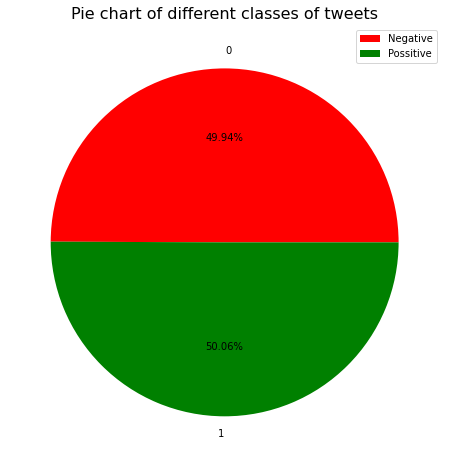

In [43]:
fig = plt.figure(figsize=(8,8))
targets = Dataset.groupby('sentiment').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend(["Negative","Possitive"])
plt.show()

### Since the difference between possitive and negative tweets is less so our datset is balanced

# Preprocessing Data  
<ol> 
    <li>Casing: Coverting all tweets into similar case (lower case)</li> 
    <li>Noise Removal: Removing hyperlinks,mentions,hashtags from tweets</li> 
    <li>Tokenization: Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as words or terms 
    <li>Stopwords Removal: Removing most common tweets (is,am,are,you,dont,the)</li> 
    <li>Text Normalisation: Lemmitization(It is the process of grouping together the different inflected forms of a word so they can be analysed as a single item) </li> 

In [44]:
def Tokenize(text): 
    tk=TweetTokenizer() 
    tokenize_tweet=tk.tokenize(text) 
    return tokenize_tweet  


def removePunctuators(tweet): 
    cleanTweets=[]  
    
    for word in tweet: 
        if(word not in string.punctuation): 
            cleanTweets.append(word) 
    
    return cleanTweets  


stopWords=set(stopwords.words('english')) 

def removeStopwords(tweet):  
    
    cleanTweets=[] 
    for word in tweet: 
        if(word not in stopWords): 
            cleanTweets.append(word) 
    
    return cleanTweets 


def Lemmitizing(tweet): 
    
    lemmatizer = WordNetLemmatizer()  
    lemmTweets=[] 
    
    for word in tweet: 
        lemmTweets.append(lemmatizer.lemmatize(word)) 
        
    return lemmTweets

def Preprocessing(text): 
    
    #Convert tweet into Lowercase 
    text=text.lower()  
    
    #Removing old style retweet text RT 
    text=re.sub(r'^RT[\s]+', '', text)
    
    #Removing all urls from tweet 
    text=re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    #Removing all @mentions and Hashtag(#) from tweet
    text=re.sub(r'\@\w+|\#','',text)
    
    #Removing all Single Numeric terms from tweet 
    text=re.sub(r'[0-9]','',text)  
    
    #Tokenizing Tweet 
    tokenizeTweet=Tokenize(text) 
    
    #Removing Punctuators 
    filteredTweet=removePunctuators(tokenizeTweet) 
    
    #Removing Stopwords 
    cleanTweet=removeStopwords(filteredTweet) 
    
    #Lemmitizing 
    lemmTweets=Lemmitizing(cleanTweet)
    
    return " ".join(lemmTweets)


In [45]:
#Checking Preprocessing function 

originalTweet="Stats for the have arrived. 1 new follower and NO unfollowers :) via http://t.co/0s8GQYOeus." 

print(originalTweet) 

cleanTweet=Preprocessing(originalTweet) 

print(cleanTweet)

Stats for the have arrived. 1 new follower and NO unfollowers :) via http://t.co/0s8GQYOeus.
stats arrived new follower unfollowers :) via


In [46]:
#Using Preprocessing to get clean Tweets 

cleanTweets=[]  

for tweet in Dataset['text']: 
    cleanTweets.append(Preprocessing(tweet))   

print(len(cleanTweets))

60000


# Converting Data into Bag of Words 
The bag-of-words model is a simplifying representation used in natural language processing.In this model,a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.   


For Example,  
<ol>
<li> John likes to watch movies. Mary likes movies too.</li> 
<li> Mary also likes to watch football games.</li> 
 </ol>   
 converts to 
 <ol> 
    <li>[1, 2, 1, 1, 2, 1, 1, 0, 0, 0]</li> 
    <li>[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]</li> 
    </ol>


In [47]:
vectorizer = CountVectorizer(max_features=5500) 

bow_vector = vectorizer.fit_transform(cleanTweets) 

bow_vector=bow_vector.toarray()  

In [48]:
# Saving vectorizer object to vectorize live tweets 
vec_file = 'vectorizer.sav'
pickle.dump(vectorizer, open(vec_file, 'wb'))

In [49]:
print(bow_vector)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# TF-IDF   
## TF(Term Frequency)   

The first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document. The Term Frequency is calculated as:  

<img src="https://static.wixstatic.com/media/1cd646_c1da199132f74052a5a6db1fc4cd3a29~mv2.png/v1/fill/w_1000,h_145,al_c,usm_0.66_1.00_0.01/1cd646_c1da199132f74052a5a6db1fc4cd3a29~mv2.png">

## IDF(Inverse Document Frequency) 

The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears. The IDF is calulated as: 


  <img src="https://learn.g2.com/hubfs/G2%20-%20TF-IDF%20Explained-1.png">

 

In [50]:
#Applying Tf-Idf vectorizer 

transformer = TfidfTransformer().fit(bow_vector)

tf_idf_vector = transformer.transform(bow_vector)  


# Splitting Dataset into Training and Test 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vector, Dataset['sentiment'], test_size=0.15, random_state=69) 
print(X_train.shape,y_train.shape) 
print(X_test.shape,y_test.shape)

(51000, 5500) (51000,)
(9000, 5500) (9000,)


# Models for Prediction  
<ol>  
    <li><h3> Mutinomial Naive Bayes</h3></li>  
    <li><h3> Complement Naive Bayes</h3></li> 
    <li><h3> Bernoulli Naive Bayes</h3></li>
    <li><h3>Logistic Regression</h3></li> 
    </ol>

# Mutinomial Naive Bayes 

In [52]:
#Naive Bayes Model training 

MNB_model=MultinomialNB() 
MNB_model.fit(X_train,y_train)  


#Prediction using Naive Bayes
predicted=MNB_model.predict(X_test) 

#Accurcy and Confusion Matrix
cf_matrix=(confusion_matrix(y_test, predicted))  
print("Accuracy:",metrics.accuracy_score(y_test, predicted)*100) 
print(cf_matrix)

Accuracy: 73.07777777777777
[[3311 1099]
 [1324 3266]]


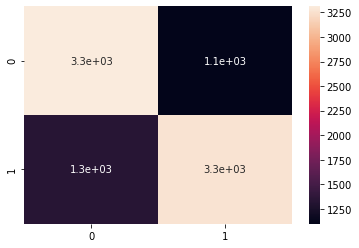

In [53]:
#Printing Confusion Matrix of prediction 

sns.heatmap(cf_matrix, annot=True) 
plt.show()

# Complement NB

In [54]:
CNB=ComplementNB()  
CNB.fit(X_train,y_train) 

predicted=CNB.predict(X_test)  

cf_matrix=(confusion_matrix(y_test, predicted))  
print("Accuracy:",metrics.accuracy_score(y_test, predicted)*100) 
print(cf_matrix) 


Accuracy: 73.08888888888889
[[3303 1107]
 [1315 3275]]


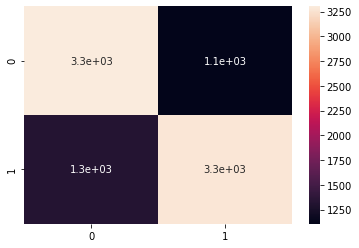

In [55]:
#Printing Confusion Matrix of prediction 
sns.heatmap(cf_matrix, annot=True) 
plt.show()

# Bernoulli Naive Bayes

In [56]:
BNB=ComplementNB()  
BNB.fit(X_train,y_train) 

predicted=BNB.predict(X_test)  

cf_matrix=(confusion_matrix(y_test, predicted))  
print("Accuracy:",metrics.accuracy_score(y_test, predicted)*100) 
print(cf_matrix) 

Accuracy: 73.08888888888889
[[3303 1107]
 [1315 3275]]


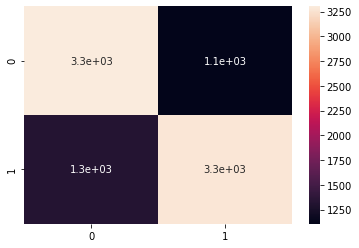

In [57]:
#Printing Confusion Matrix of prediction 
sns.heatmap(cf_matrix, annot=True) 
plt.show()

# Logistic Regression

In [58]:
#Logistic Regression model training   

LR_model = LogisticRegression(random_state=0,solver='lbfgs')   
LR_model.fit(X_train,y_train) 
 
#Prediction using Logisitc Regression Model  

predicted = LR_model.predict(X_test) 


#Calculating Acuuracy and Confusion Matrix
print("Accuracy:",metrics.accuracy_score(y_test, predicted)*100)  

cf_matrix=(confusion_matrix(y_test, predicted))  

print(cf_matrix)






Accuracy: 75.12222222222222
[[3198 1212]
 [1027 3563]]


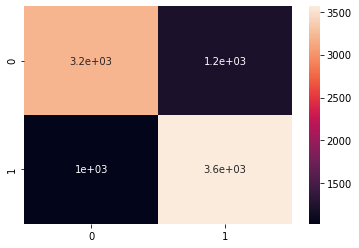

In [59]:
sns.heatmap(cf_matrix, annot=True) 
plt.show()

# Voting Classifier  
A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting,

In [60]:
#Making list of all Models  

from sklearn.naive_bayes import ComplementNB 
from sklearn.naive_bayes import BernoulliNB

estimator=[] 
estimator.append(("MNB",MultinomialNB())) 
estimator.append(("LR",LogisticRegression(random_state=0,solver='lbfgs')))
estimator.append(("BNB",BernoulliNB())) 
estimator.append(("CNB",ComplementNB()))


from sklearn.ensemble import VotingClassifier 

Voting_model= VotingClassifier(estimators = estimator, voting ='soft')
Voting_model.fit(X_train, y_train) 



predicted = Voting_model.predict(X_test)  


print("Accuracy:",metrics.accuracy_score(y_test, predicted)*100)  

cf_matrix=(confusion_matrix(y_test, predicted))   

print(cf_matrix) 


  

Accuracy: 74.84444444444445
[[3241 1169]
 [1095 3495]]


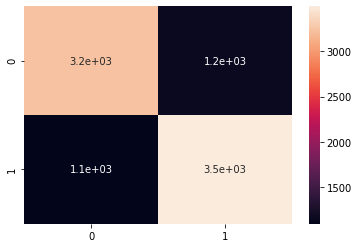

In [61]:
#Plotting Confuison Matrix 

sns.heatmap(cf_matrix, annot=True) 
plt.show()

In [62]:
#Now lets try some example to predict  

test_Tweets=["Very happy by @JustinTreadeau decision to give candaian citizen to international students", 
             "The GST of 15% on electronics item is quiet high government have to do some thing", 
             "There is no ventilators left in Delhi the Delhi government and Central have to do some thing #Covid19 #lockdown", 
             "Impressed by the @RameshPokhriyal decision of new education policy #PadegaIndia", 
             "The current situation of Isarel and palestine is sad hoping for the good #IsarelvsPalestine", 
             "@BillGates get divorced with his wife", 
             "Happy after getting profit from investing in dogecoin crypto currency #dogecoin #Cryptocurrency", 
             "Great to see @VitalikButerin co-founder of etherum become a billonaire at the age of 27"
            ]  

for tweets in test_Tweets: 
    tweets = Preprocessing(tweets)
    vectorized_sentence = vectorizer.transform([tweets]).toarray()
    print(LR_model.predict(vectorized_sentence))

[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]


## Saving Model using Pickle 

In [63]:
#Since logisitic regression has greater accuracy than any other model so we will saving linear regression model  

LR_model = LogisticRegression(random_state=0,solver='lbfgs')   
LR_model.fit(X_train,y_train)  

buffer=open("Model.sav",'wb')  

pickle.dump(LR_model,buffer)

buffer.close()  

In [64]:
buffer=open("Model.sav",'rb')
Voting_model=pickle.load(buffer) 
buffer.close()

for tweets in test_Tweets: 
    tweets = Preprocessing(tweets)
    vectorized_sentence = vectorizer.transform([tweets]).toarray()
    print(Voting_model.predict(vectorized_sentence))

[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
